# Manual experiments with dynamics-related metrics

> ✅ This notebook can be run locally.

## Installing required packages

In [1]:
%pip install -r ../requirements.txt

  Obtaining dependency information for ipykernel==6.28.0 from https://files.pythonhosted.org/packages/b0/71/348c659f0fbbf526ca77fae9fd31d43a3c90d4d60ae3df6d477055ee90d5/ipykernel-6.28.0-py3-none-any.whl.metadata
  Using cached ipykernel-6.28.0-py3-none-any.whl.metadata (6.0 kB)
Using cached ipykernel-6.28.0-py3-none-any.whl (114 kB)
  Attempting uninstall: ipykernel
    Found existing installation: ipykernel 6.22.0
    Uninstalling ipykernel-6.22.0:
      Successfully uninstalled ipykernel-6.22.0
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Importing tested methods

In [2]:
import os  # noqa: E402
import sys  # noqa: E402

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from wimu10 import (  # noqa: E402
    compute_dynamics_histogram,
    compute_dynamics_levels_histogram,
    compute_dynamics_variability,
    compute_dynamics_levels_variability,
    compute_dynamics_transition_matrix,
    compute_dynamics_levels_transition_matrix,
)

## Setting up a dataset

In [3]:
dataset = 'musicnet'  # 'musicnet', 'maestro', 'nesmdb', 'emopia', 'lakh'

In [4]:
from setup_dataset import download_muspy_midi, change_data_path  # noqa: E402

change_data_path('../data/raw/')
downloaded_dataset = download_muspy_midi(dataset)  # Performs required extraction and conversion

print(f'The chosen dataset ({type(downloaded_dataset).__name__}) has {len(downloaded_dataset)} elements.')

Skip downloading as the `.muspy.success` file is found.
Skip extracting as the `.muspy.success` file is found.
Skip conversion as the `.muspy.success` file is found.
The chosen dataset (str) has 8 elements.


## Processing a file (of choice)

In [5]:
# Choose a file from the dataset by putting its index here
# The index should be the zero-based index of a file converted by MusPy when setting up the dataset
file_index: int = 329

# Alternatively you can put a full (relative or absolute) path to a MIDI file to be processed here
# Leave empty to use the file_index field
full_file_path: str = ''

Loaded file: data\raw\musicnet\_converted\329.json (source filename: 1777_sy_sps23.mid, title: untitled)

=== PROCESSING TRACK #0 ===


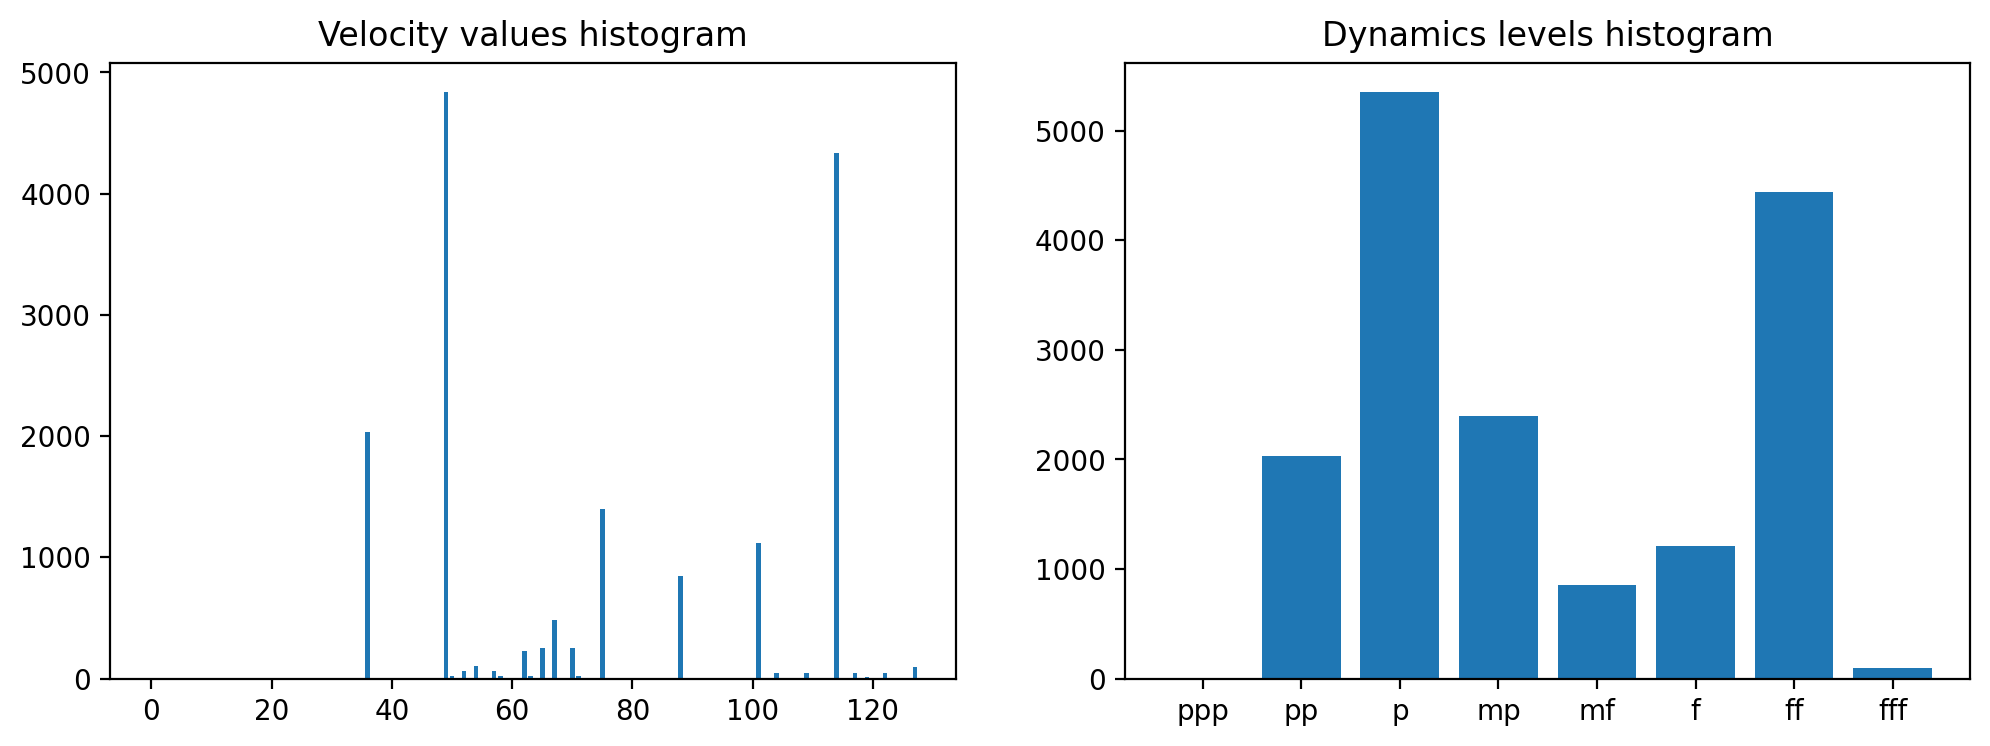

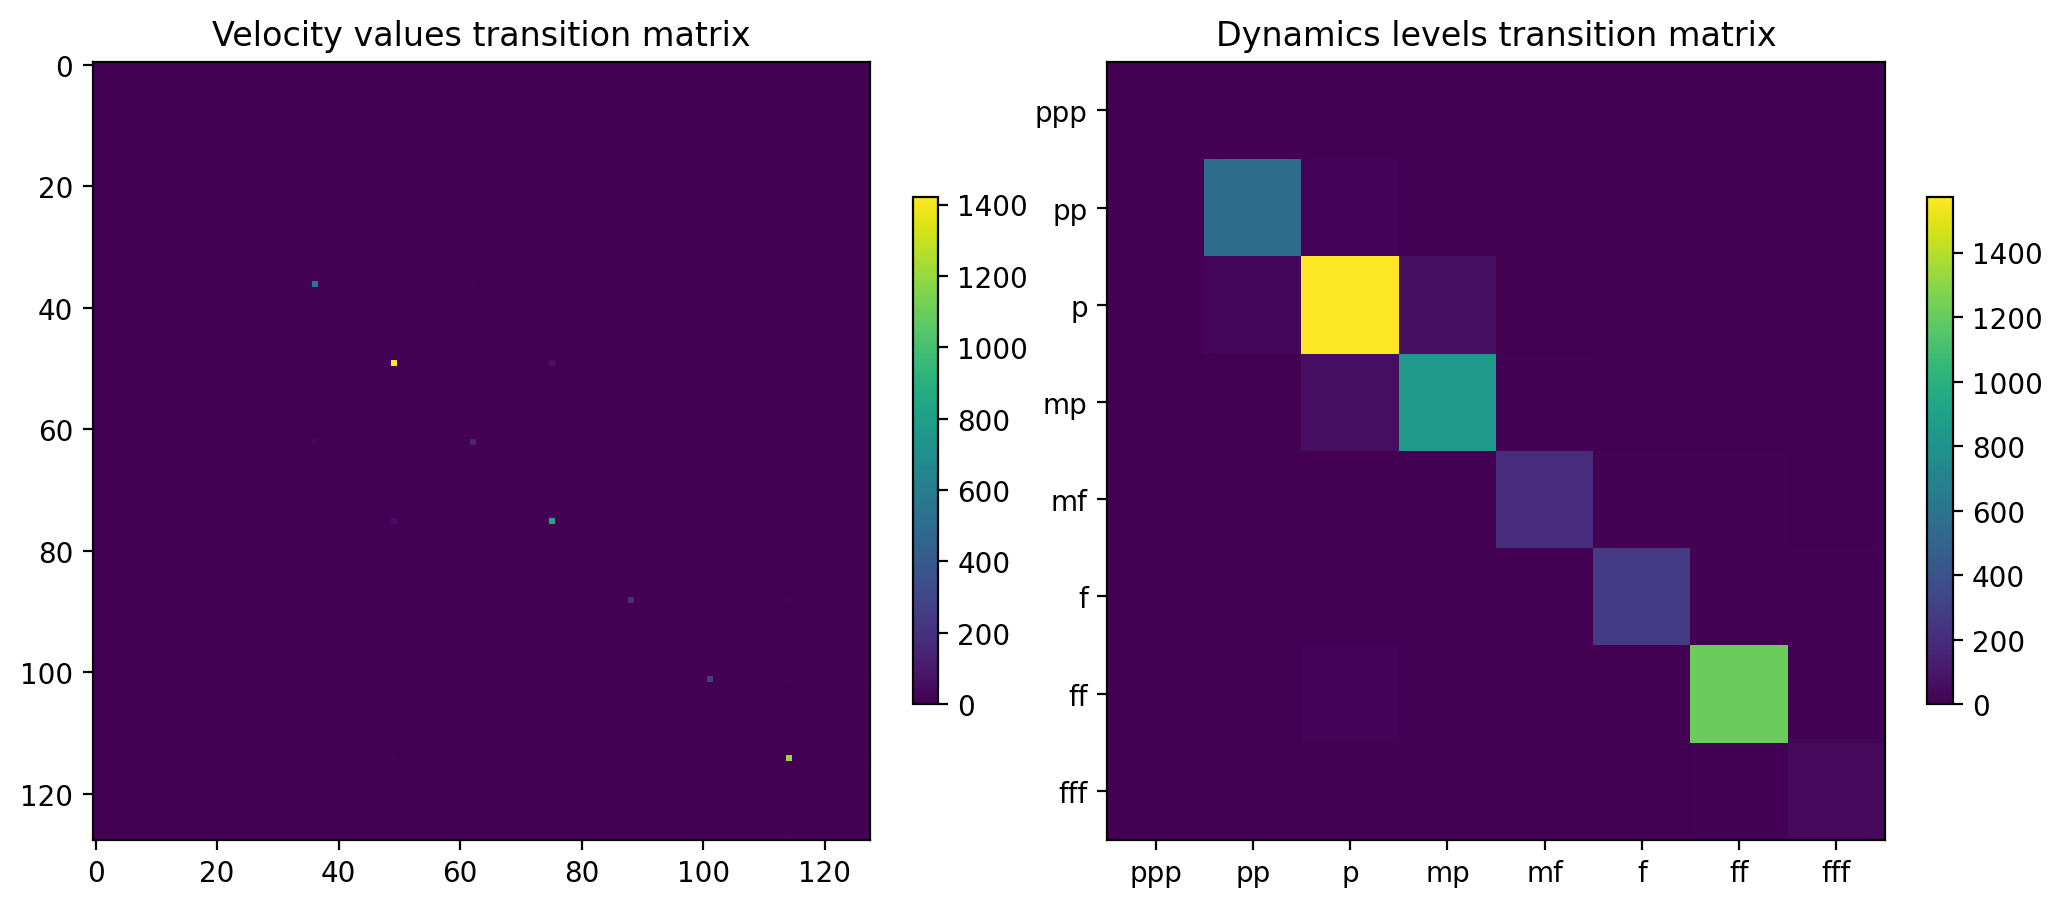

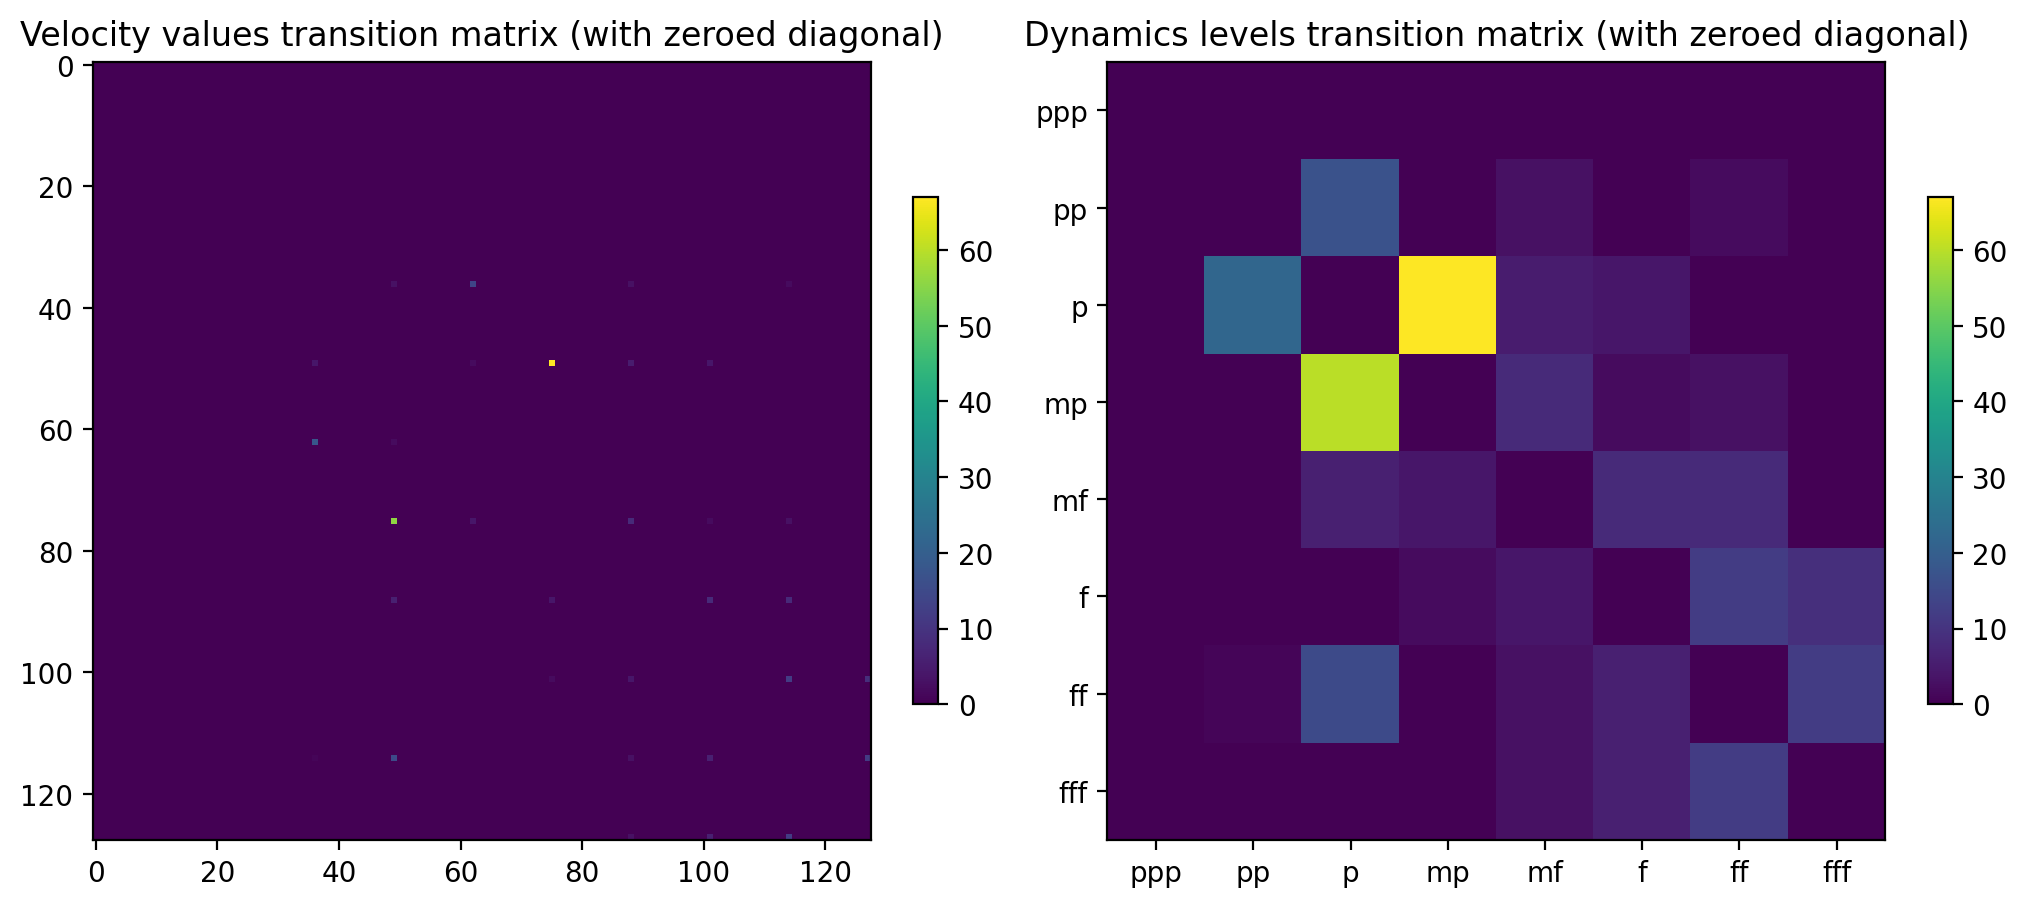

Velocity values variability: 6.16% (308 / 5000)
Dynamics levels variability:
- lesser changes (1..2 levels): 5.46% (273 / 5000)
- greater changes (3+ levels): 0.62% (31 / 5000)

=== PROCESSING TRACK #1 ===


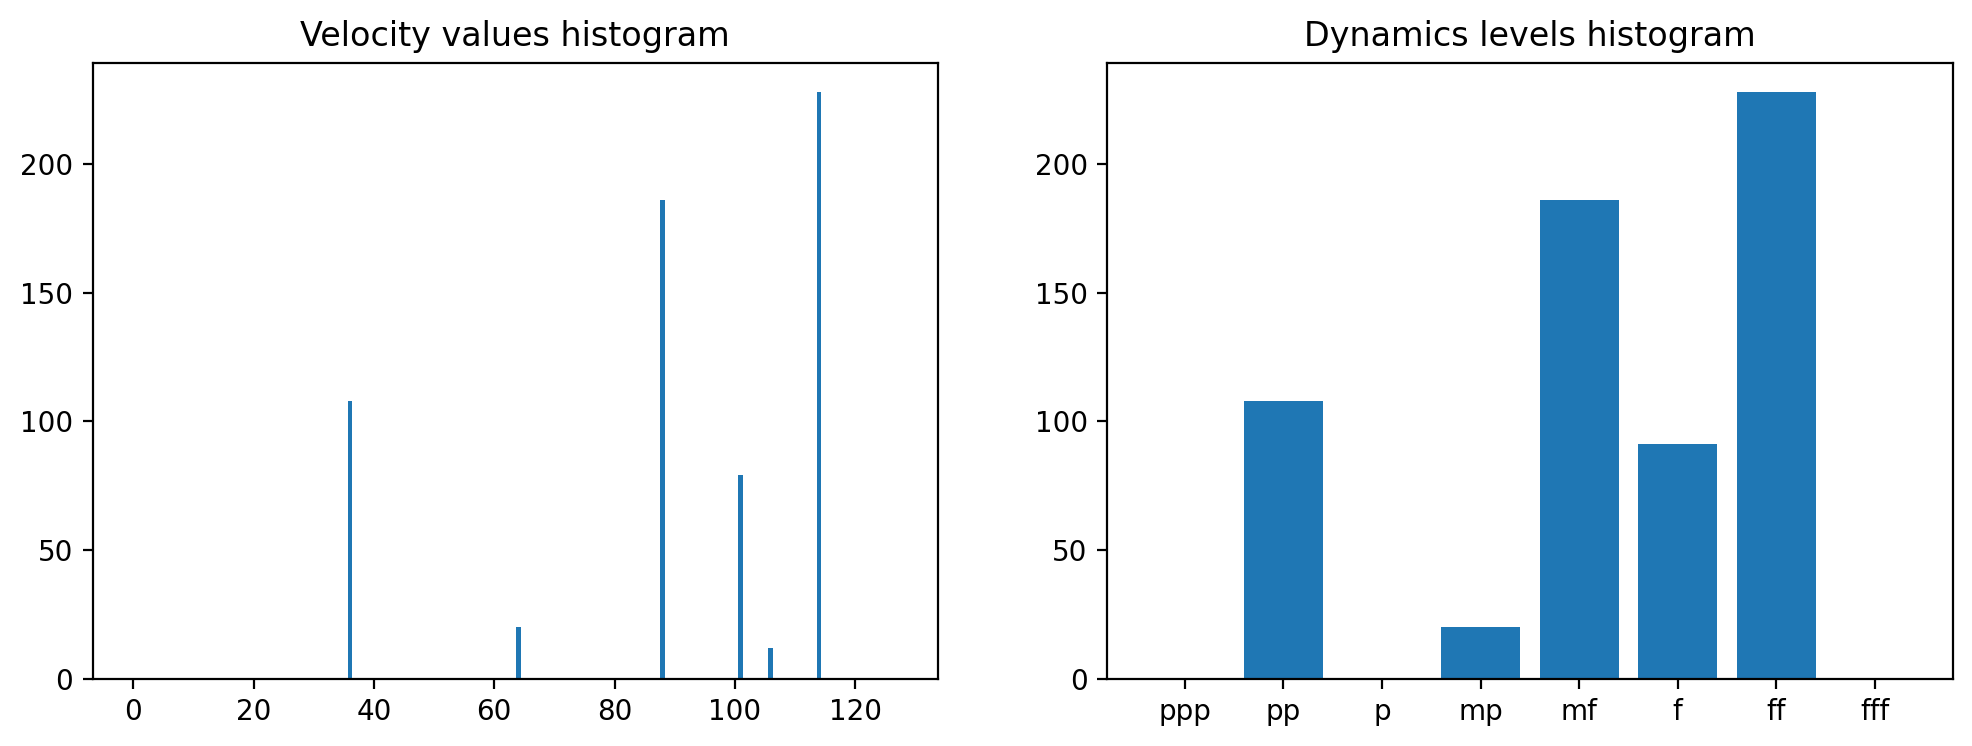

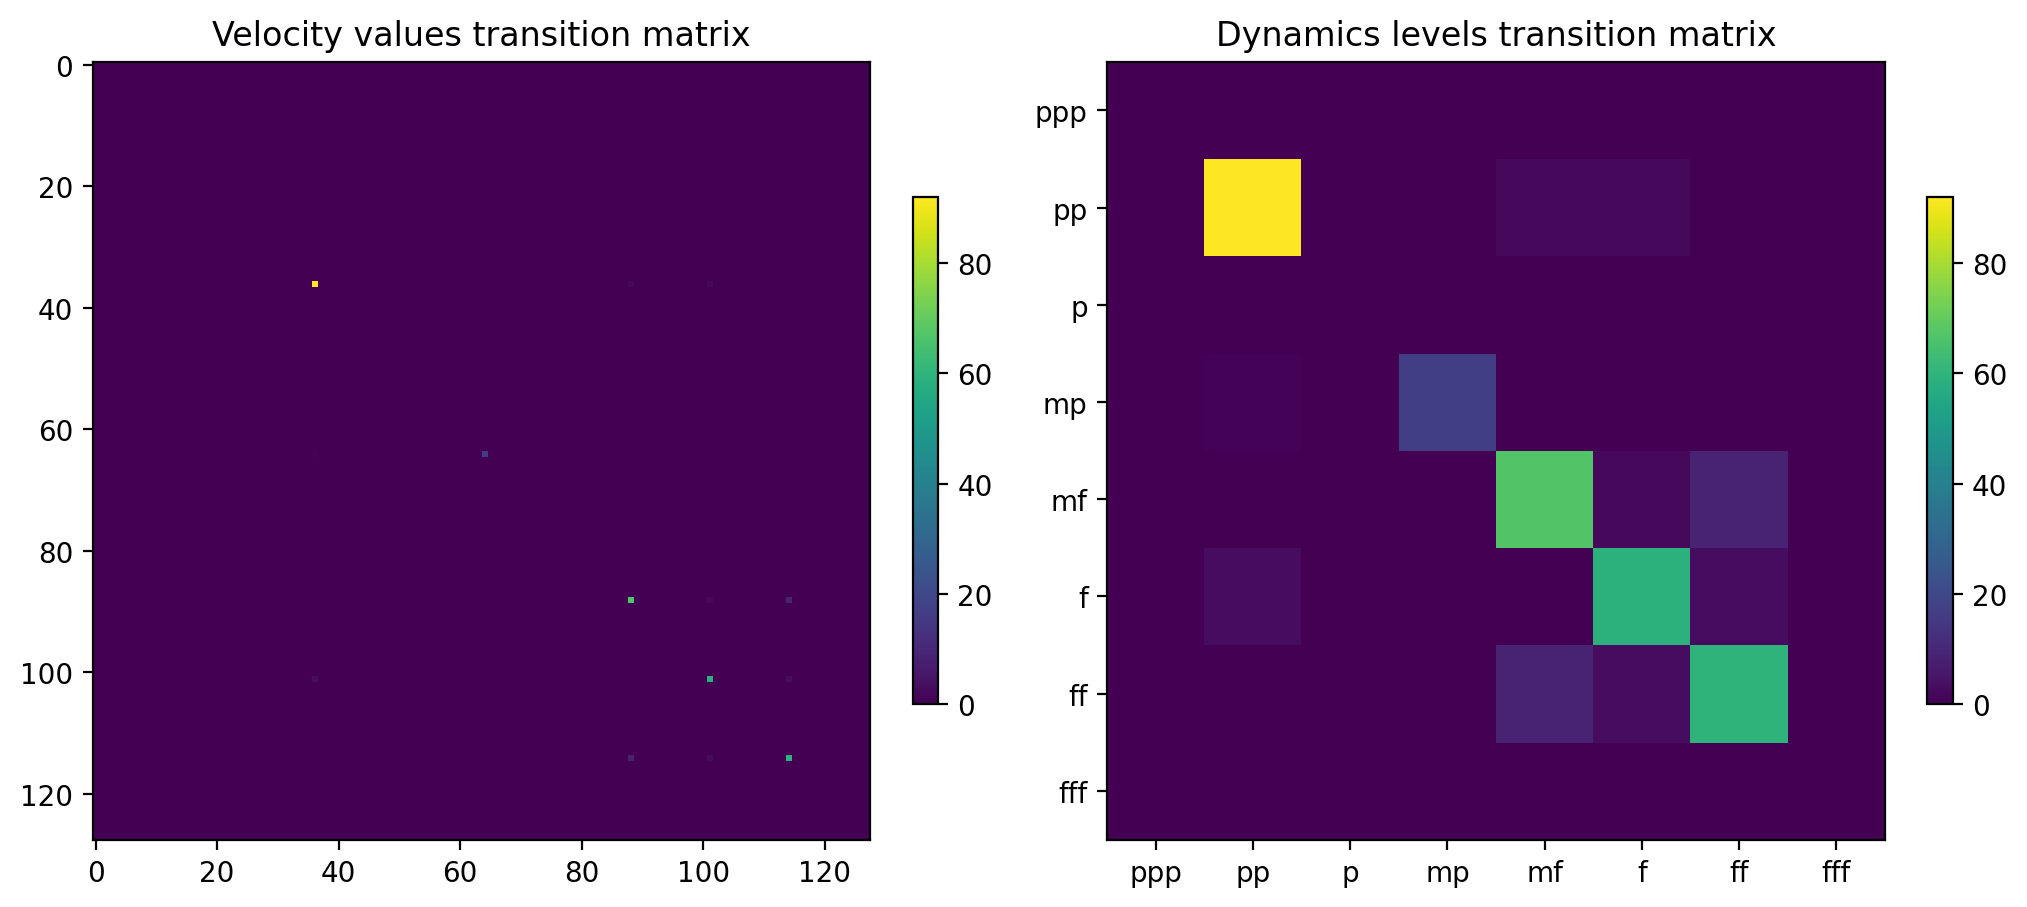

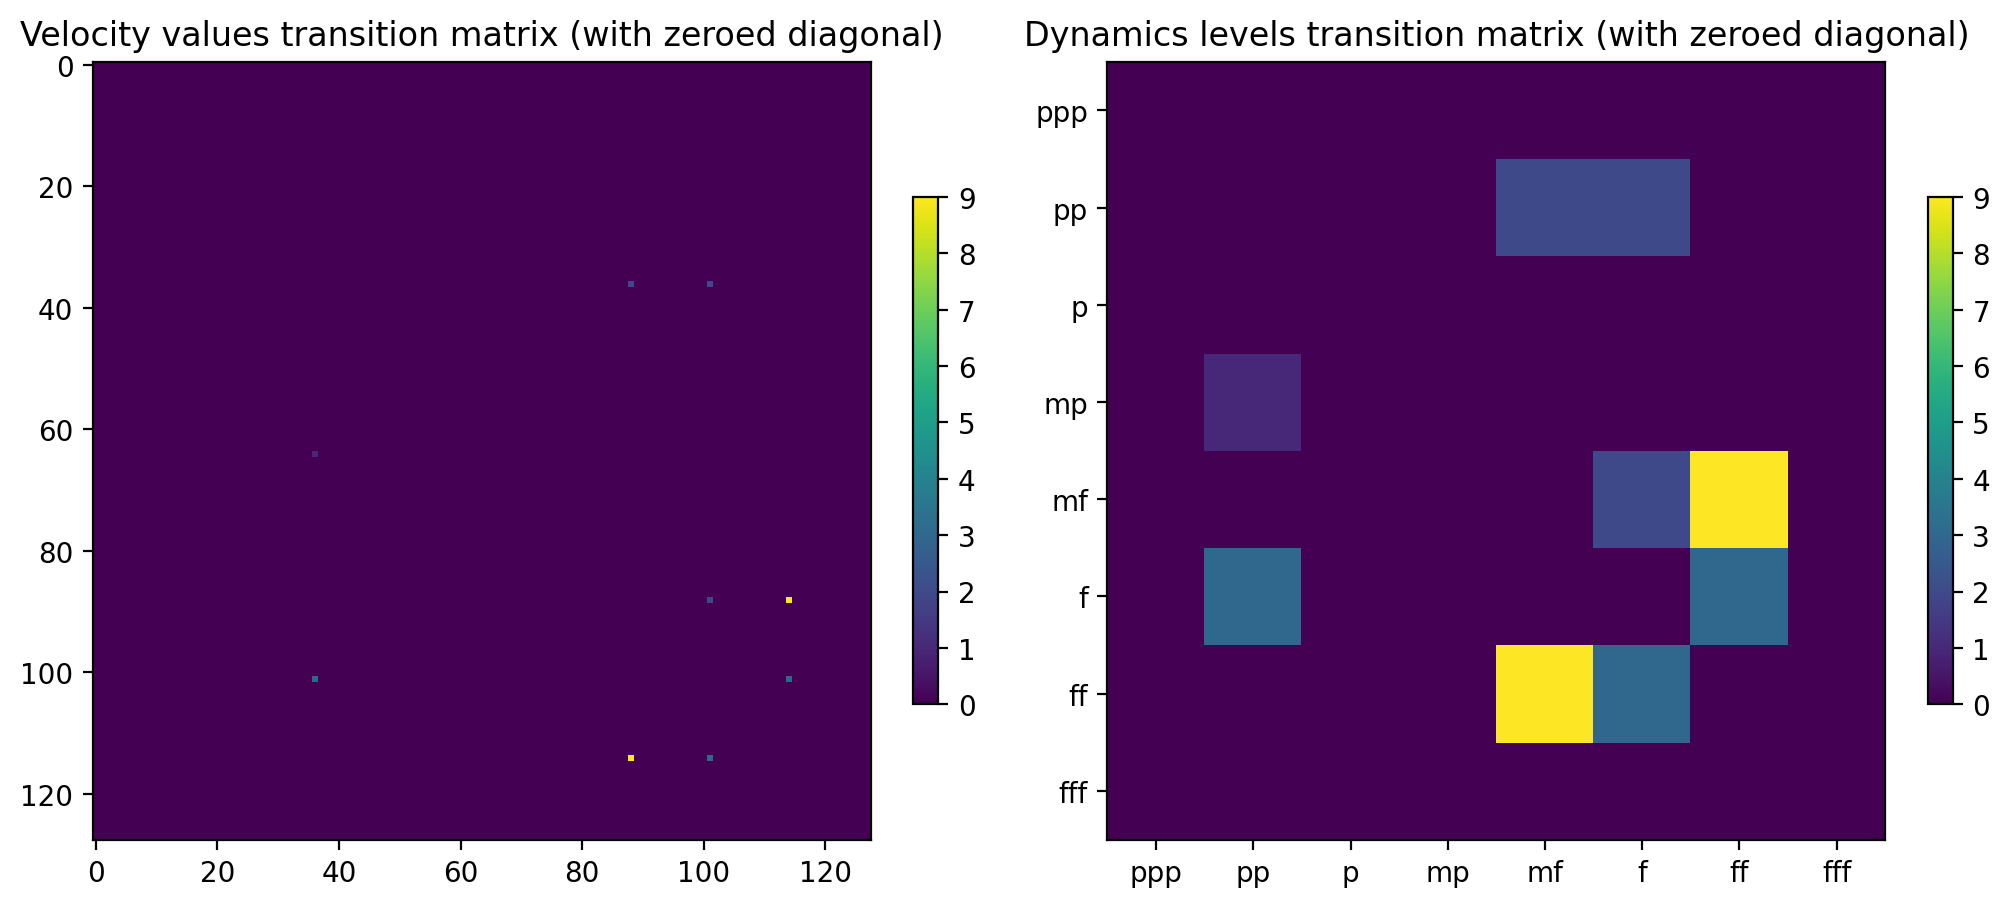

Velocity values variability: 10.33% (34 / 329)
Dynamics levels variability:
- lesser changes (1..2 levels): 8.21% (27 / 329)
- greater changes (3+ levels): 2.13% (7 / 329)

=== PROCESSING TRACK #2 ===


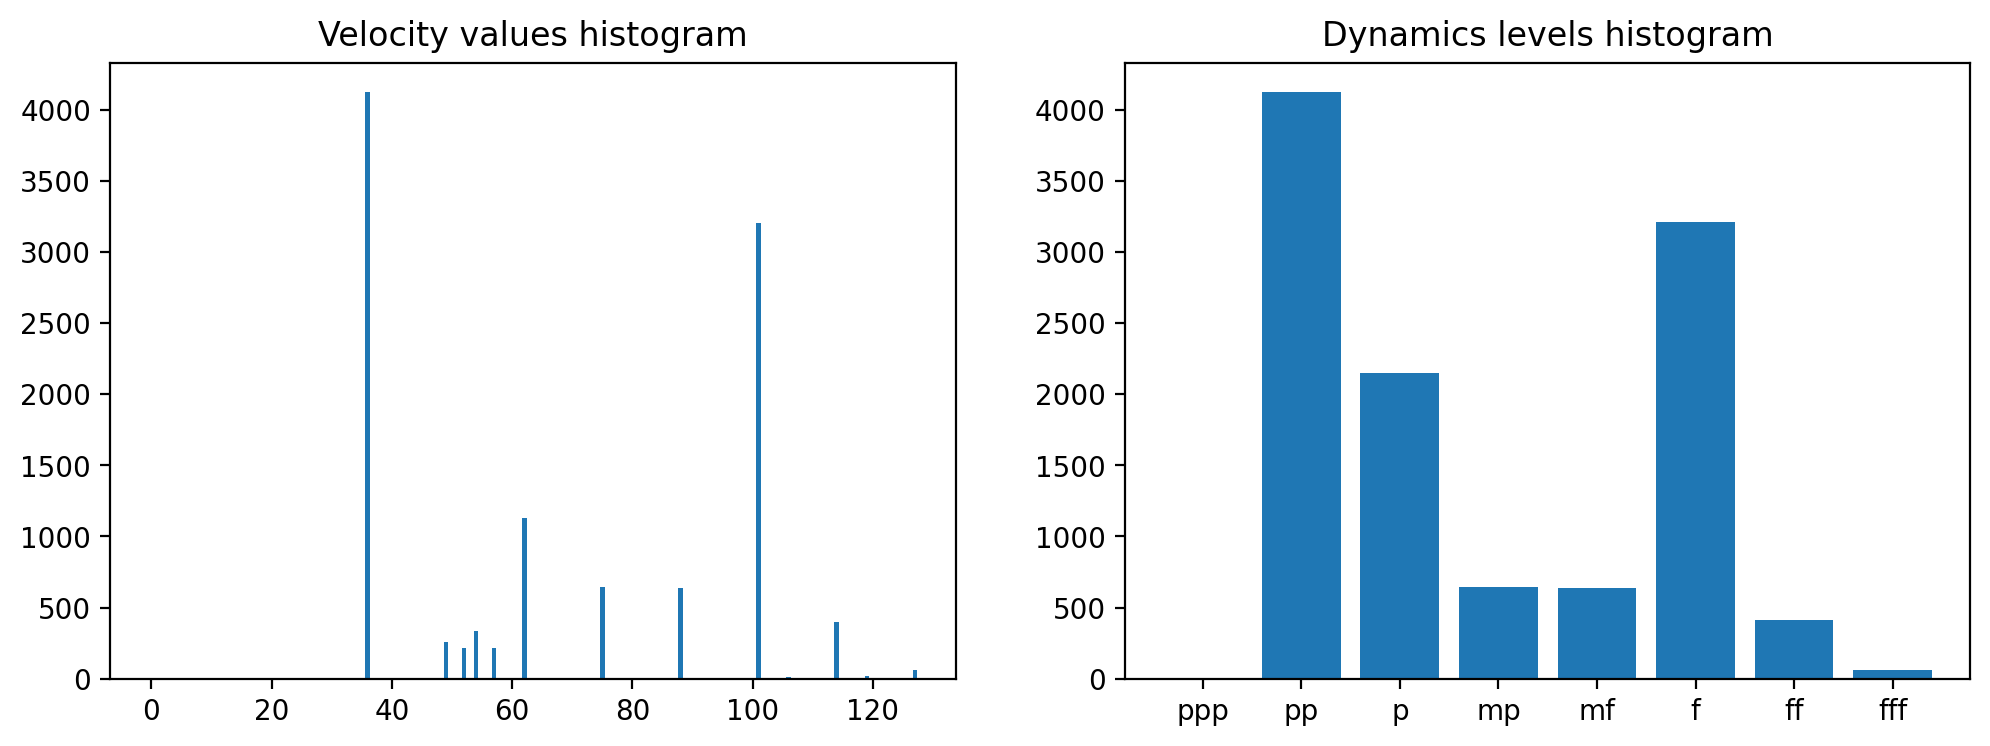

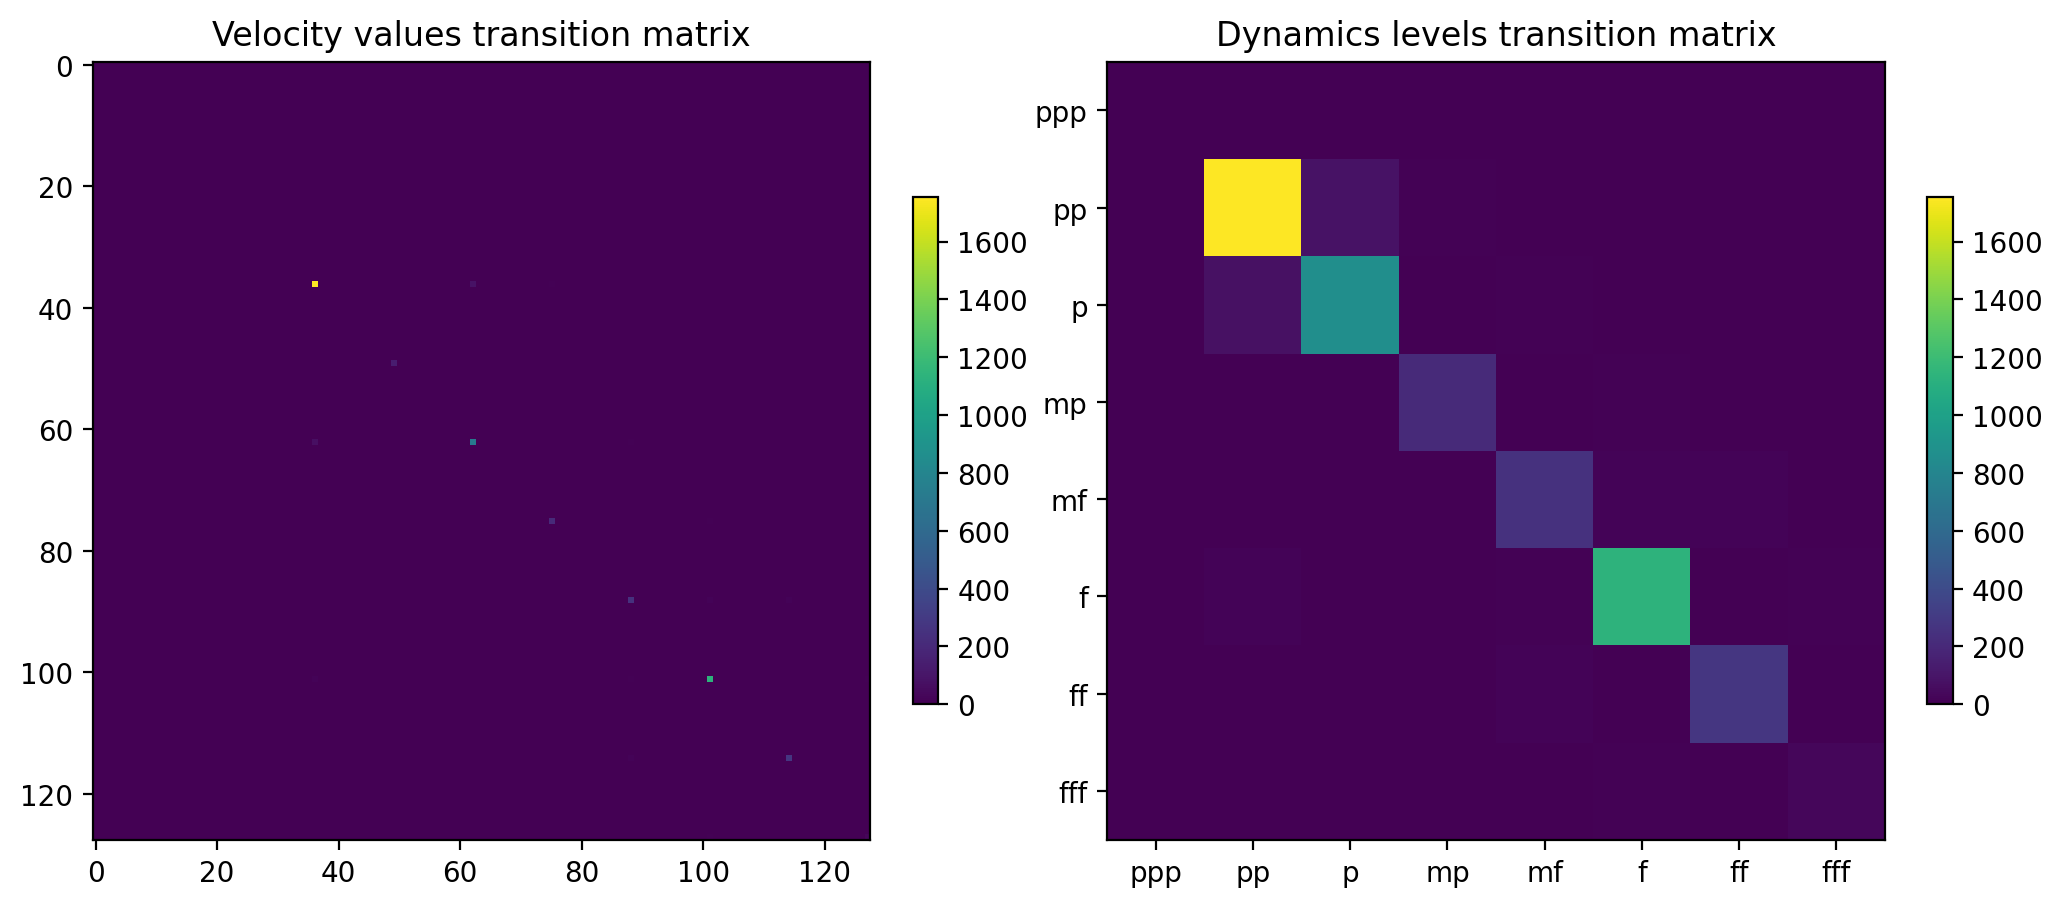

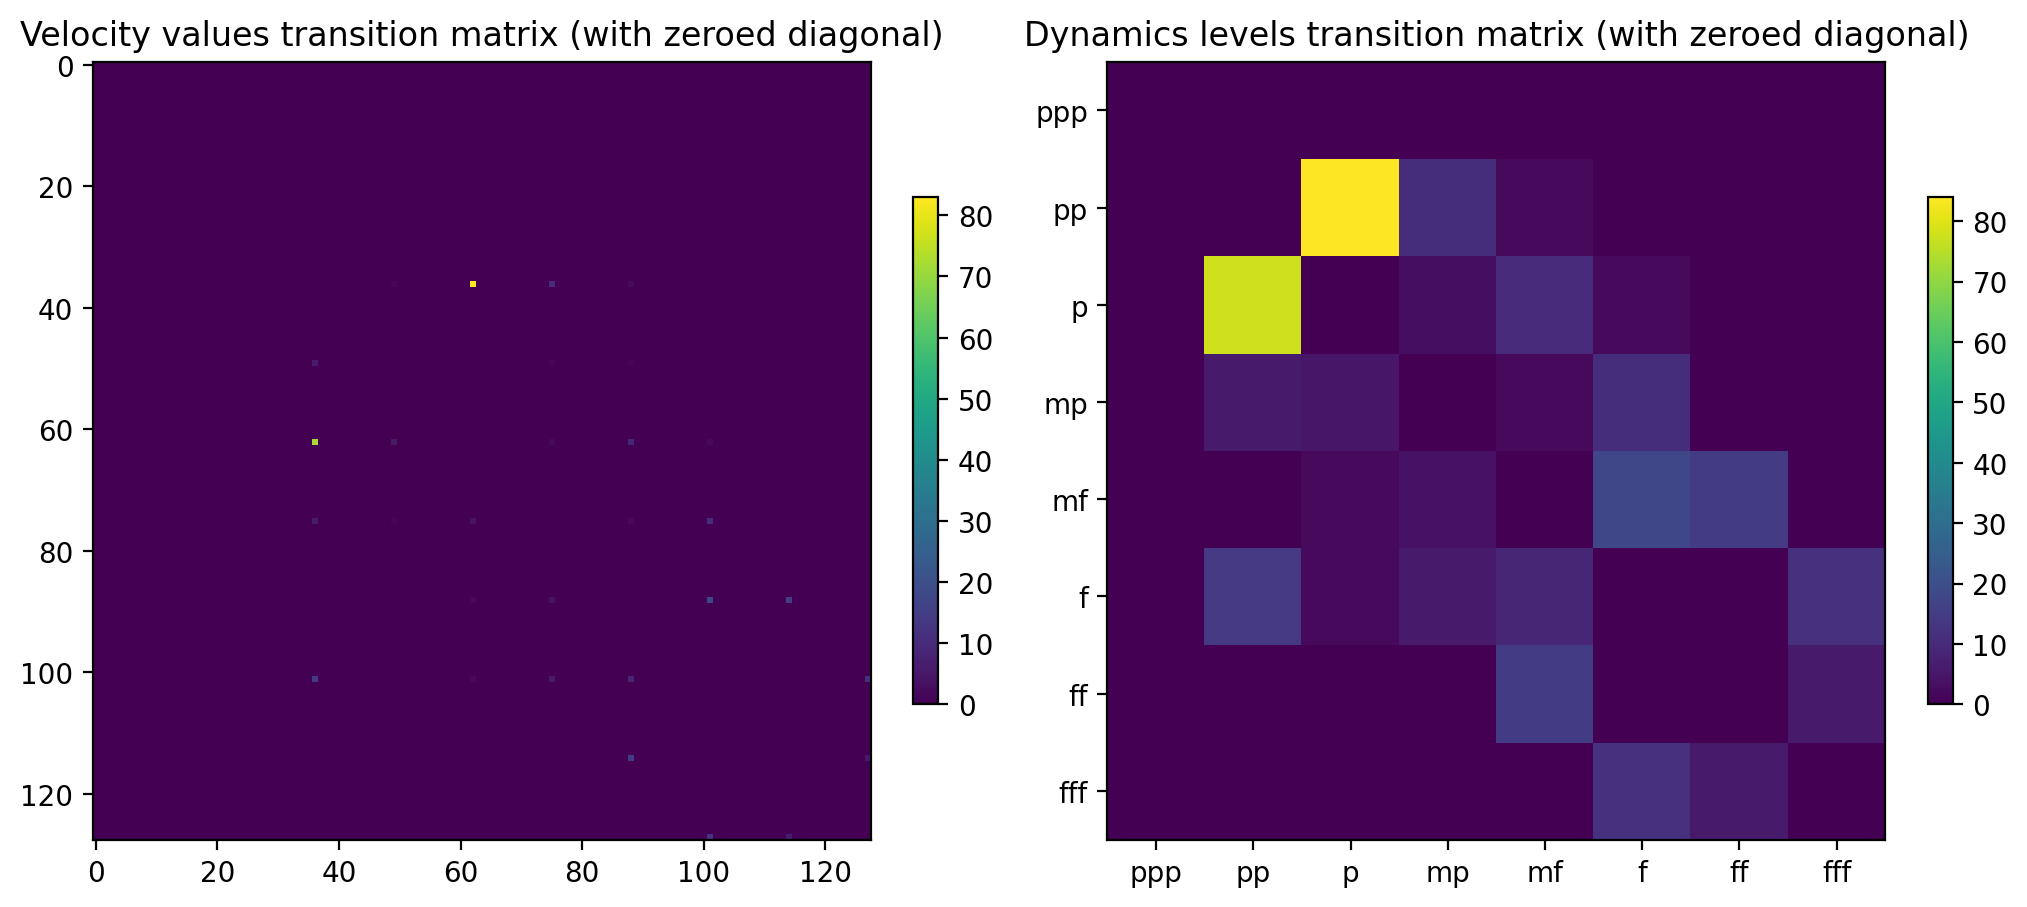

Velocity values variability: 7.02% (341 / 4859)
Dynamics levels variability:
- lesser changes (1..2 levels): 6.48% (315 / 4859)
- greater changes (3+ levels): 0.41% (20 / 4859)

=== PROCESSING TRACK #3 ===


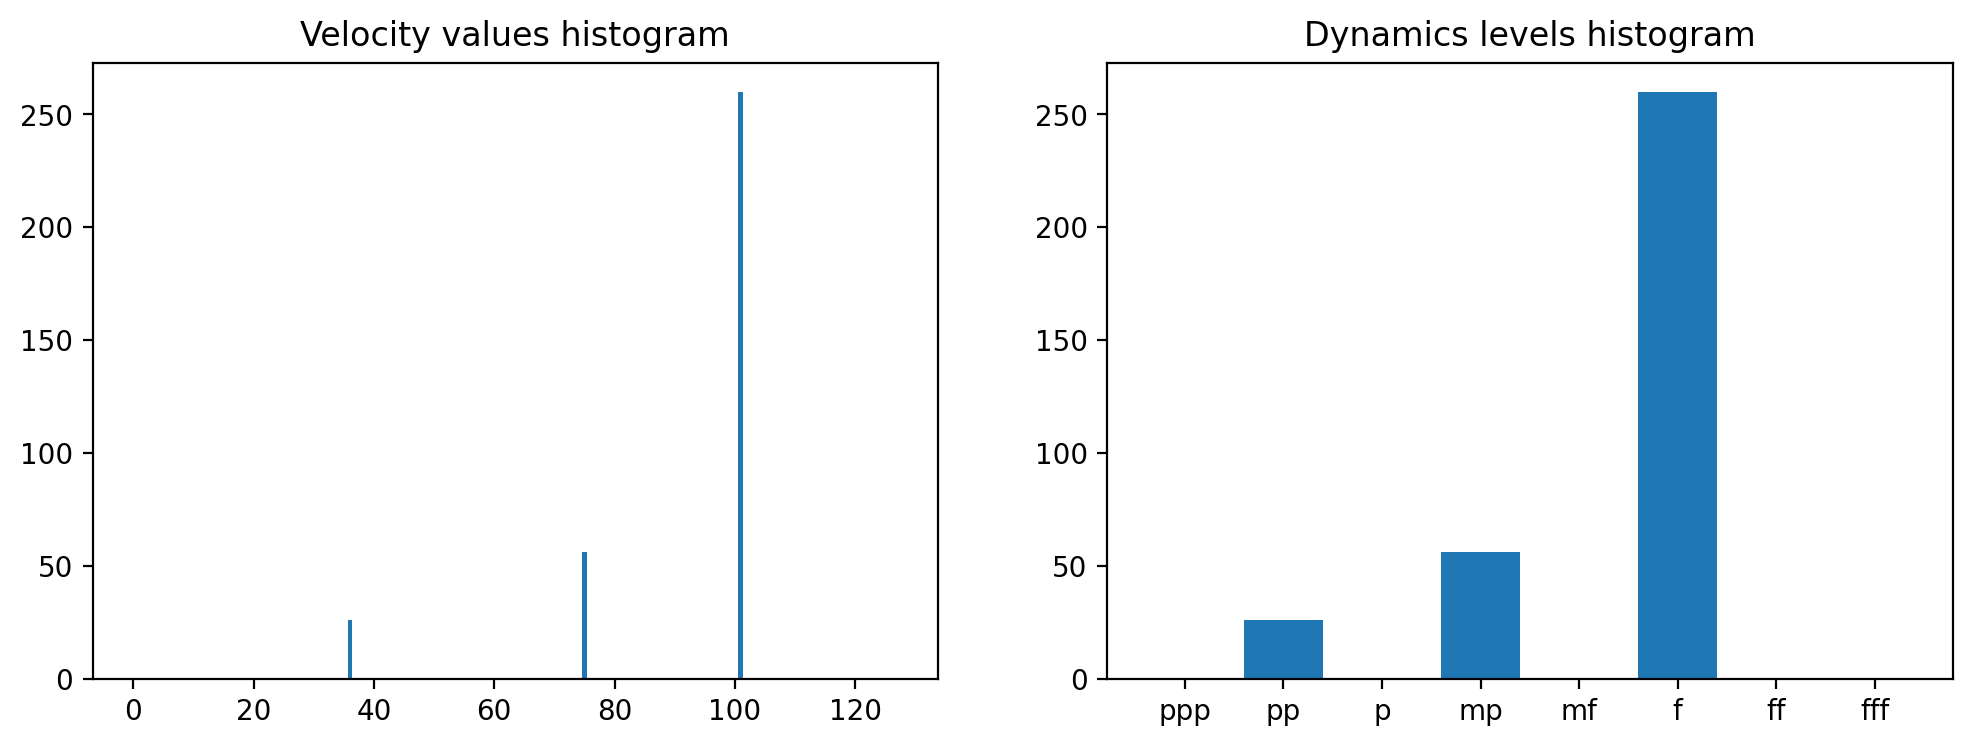

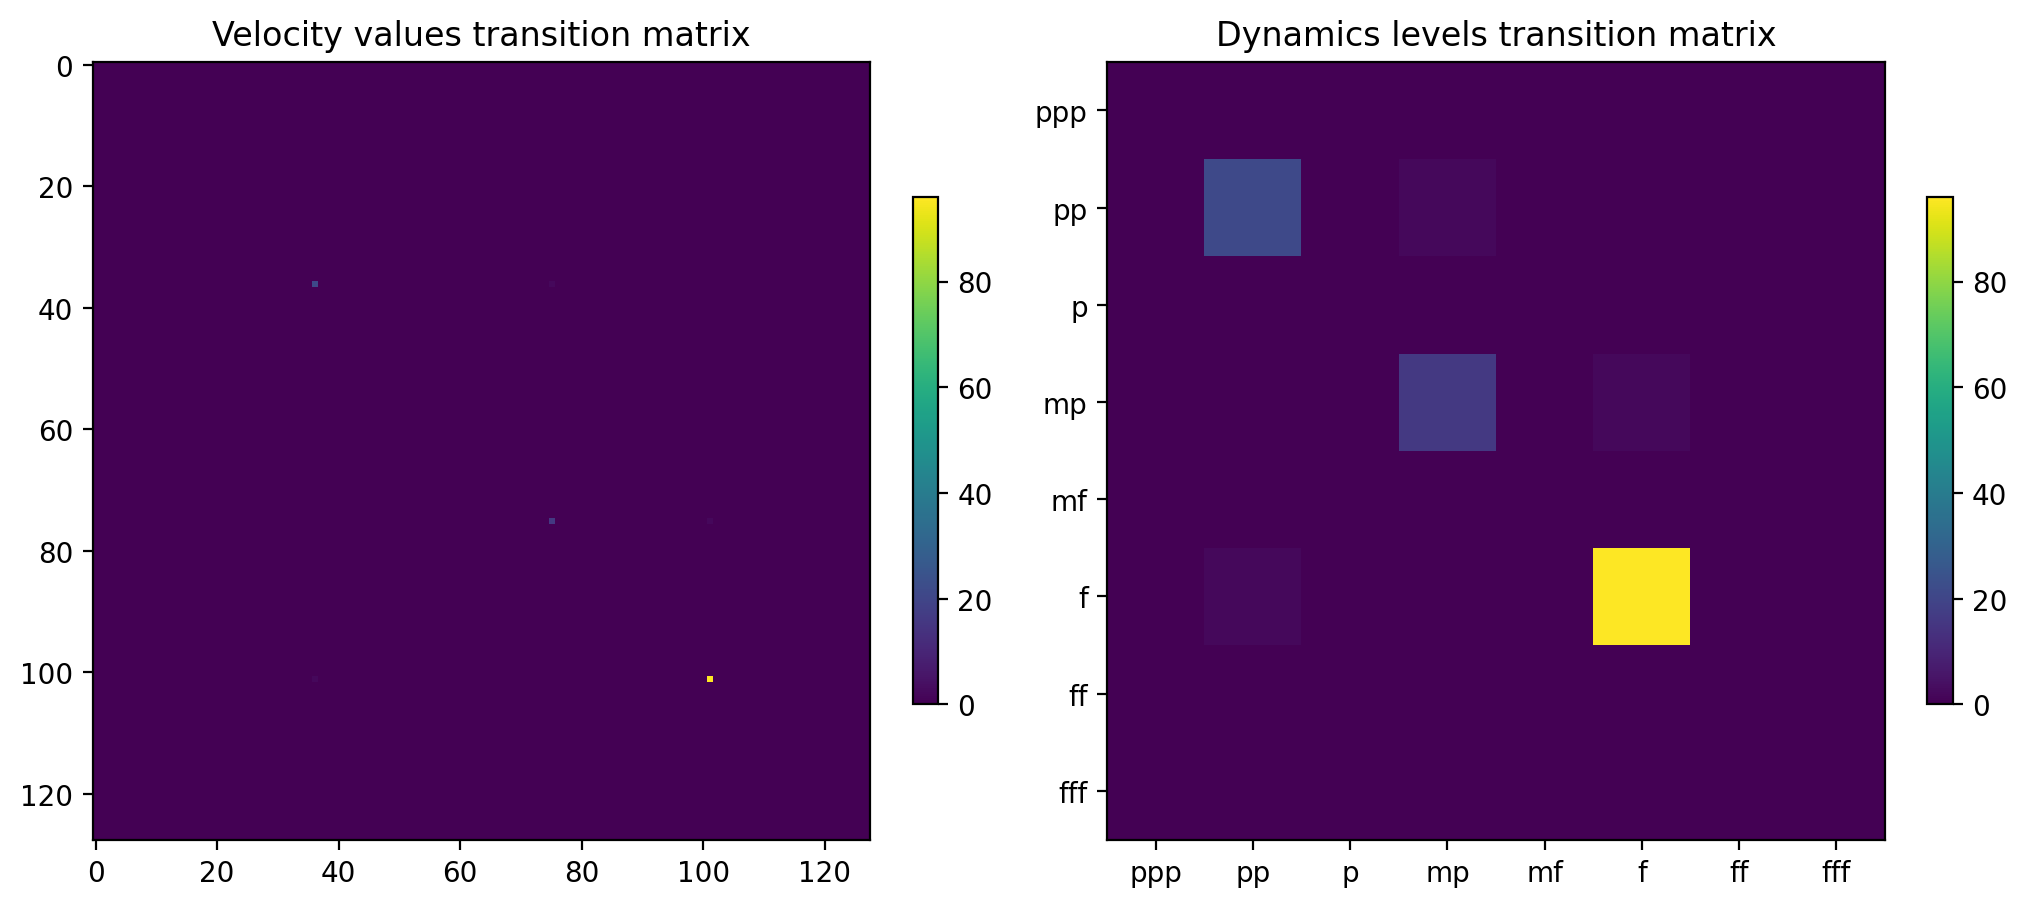

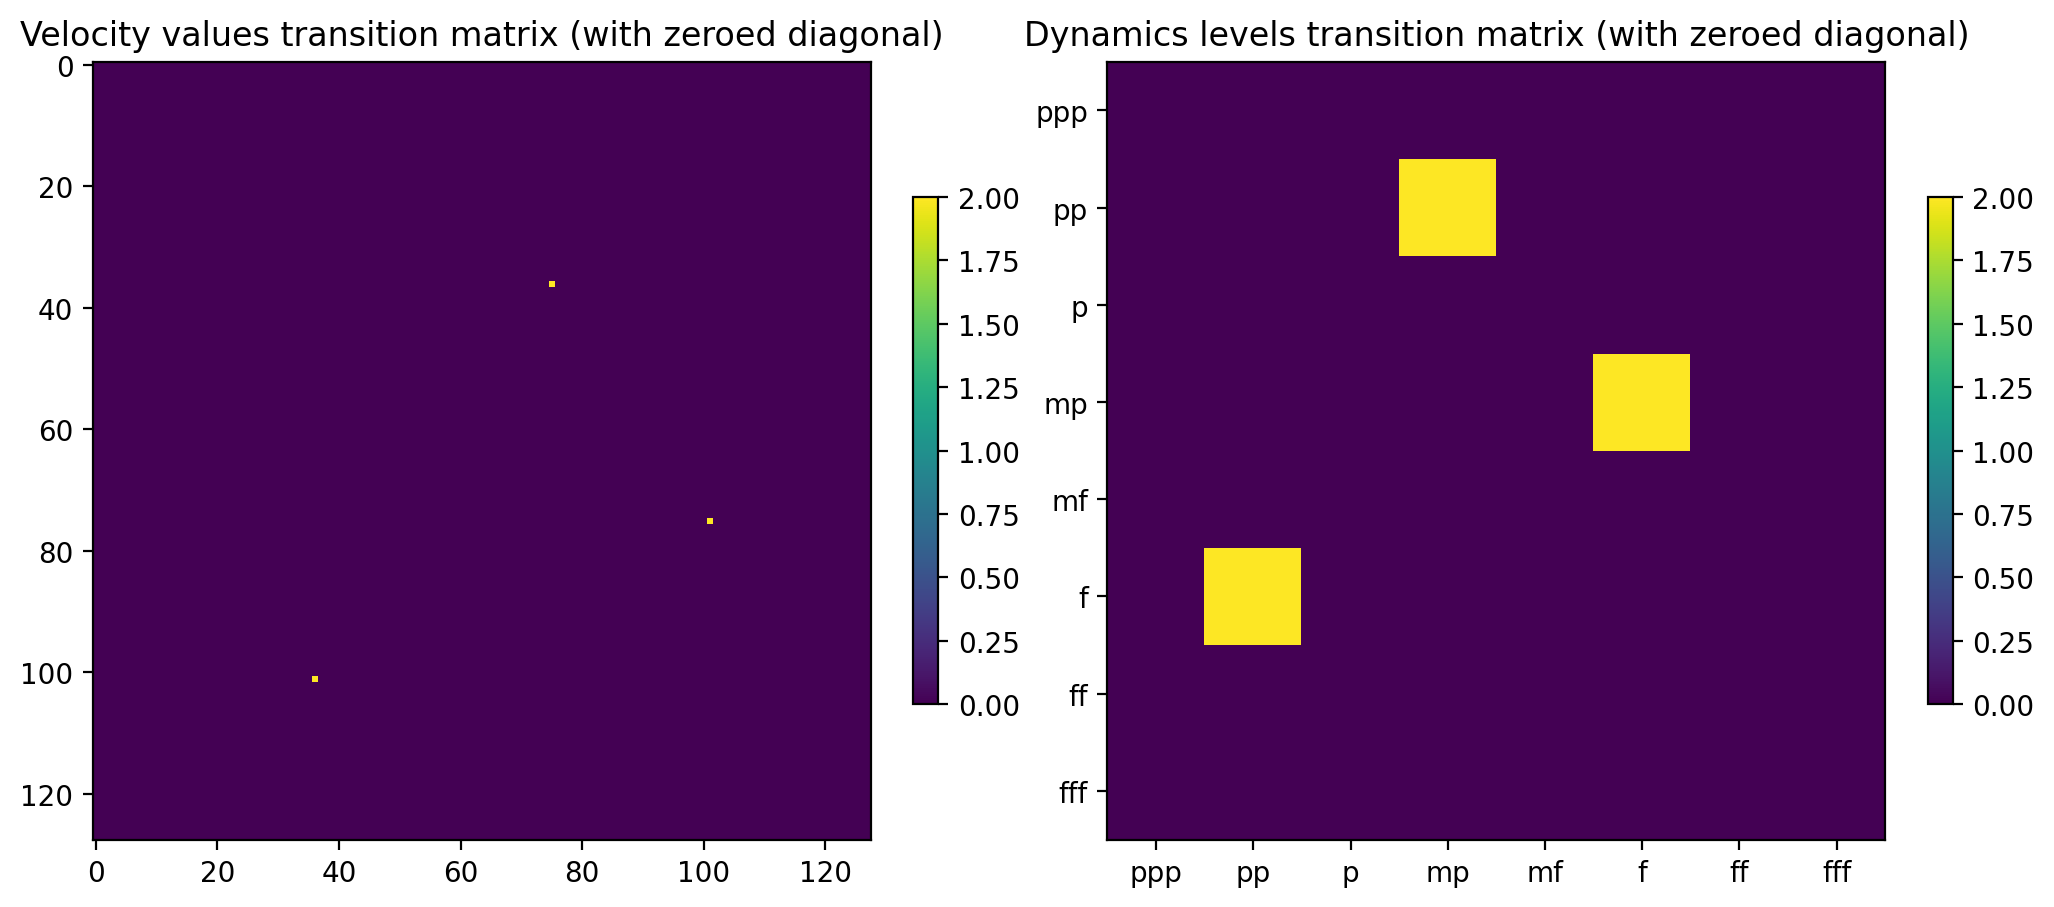

Velocity values variability: 4.32% (6 / 139)
Dynamics levels variability:
- lesser changes (1..2 levels): 2.88% (4 / 139)
- greater changes (3+ levels): 1.44% (2 / 139)


In [6]:
from os import listdir  # noqa: E402
from pathlib import Path  # noqa: E402

import matplotlib.pyplot as plt  # noqa: E402
import muspy as mp  # noqa: E402
import numpy as np  # noqa: E402

from setup_dataset import DATA_RAW_PATH  # noqa: E402

full_path_used = full_file_path != ''

if full_path_used:
    path = Path(full_file_path)
else:
    extension = '.json'
    first_dataset_entry = sorted(
        filter(
            lambda filename: filename.endswith(extension),
            listdir(Path(f'{DATA_RAW_PATH}{dataset}/_converted/'))
        )
    )[0]
    first_dataset_entry = first_dataset_entry[:-len(extension)]
    padding_len = len(first_dataset_entry)
    path = Path(f'{DATA_RAW_PATH}{dataset}/_converted/{str(file_index).zfill(padding_len)}{extension}')

if not path.exists() or not path.is_file():
    raise Exception(f'There is no file at path: {path}')

if full_path_used:
    music = mp.read_midi(path)
else:
    music = mp.load_json(path)

print(f'Loaded file: {path} (source filename: {music.metadata.source_filename}, title: {music.metadata.title})')

resolution = int(music.resolution / 4)  # MIDI resolution is in quarternotes, divided by 4 gives 1/16 note accuracy
track_end = music.get_end_time()
total_scores = []
dynamics_levels = ['ppp', 'pp', 'p', 'mp', 'mf', 'f', 'ff', 'fff']  # Default dynamics levels used

for track_idx, track in enumerate(music.tracks):
    print()
    print(f'=== PROCESSING TRACK #{track_idx} ===')
    if len(track.notes) == 0:
        total_scores.append(None)
        print(f'  Skipping track {track_idx} (it has 0 notes).')
        continue

    # Calculate all metrics
    bins = compute_dynamics_histogram(music, track_idx, resolution=resolution, track_end=track_end)
    level_bins = compute_dynamics_levels_histogram(music, track_idx, resolution=resolution, track_end=track_end)
    variability = compute_dynamics_variability(music, track_idx, resolution=resolution, track_end=track_end)
    level_variability = compute_dynamics_levels_variability(music, track_idx, resolution=resolution, track_end=track_end)
    transition_matrix = compute_dynamics_transition_matrix(music, track_idx, resolution=resolution, track_end=track_end)
    level_transition_matrix = compute_dynamics_levels_transition_matrix(
        music, track_idx, resolution=resolution, track_end=track_end
    )

    # Add metrics to a list (for saving it to a file later)
    total_scores.append(
        {
            'histogram': bins,
            'level_histogram': level_bins,
            'variability': variability,
            'level_variability': level_variability,
            'transition_matrix': transition_matrix.tolist(),
            'level_transition_matrix': level_transition_matrix.tolist(),
        }
    )

    # Plotting histograms
    _, (a1, a2) = plt.subplots(1, 2, figsize=(12, 4))
    a1.bar(range(len(bins)), bins)
    a1.set_title('Velocity values histogram')
    a2.bar(range(len(level_bins)), level_bins)
    a2.set_title('Dynamics levels histogram')
    a2.set_xticks(range(len(dynamics_levels)), dynamics_levels)
    plt.show()

    # Plotting transition matrices
    fig, (a1, a2) = plt.subplots(1, 2, figsize=(12, 6))
    plt.colorbar(a1.imshow(transition_matrix), ax=a1, fraction=0.03)
    a1.set_title('Velocity values transition matrix')
    plt.colorbar(a2.imshow(level_transition_matrix), ax=a2, fraction=0.03)
    a2.set_title('Dynamics levels transition matrix')
    a2.set_xticks(range(len(dynamics_levels)), dynamics_levels)
    a2.set_yticks(range(len(dynamics_levels)), dynamics_levels)
    plt.show()

    # Plotting transition matrices with zeroed diagonal
    np.fill_diagonal(transition_matrix, 0)
    np.fill_diagonal(level_transition_matrix, 0)
    fig, (a1, a2) = plt.subplots(1, 2, figsize=(12, 6))
    plt.colorbar(a1.imshow(transition_matrix), ax=a1, fraction=0.03)
    a1.set_title('Velocity values transition matrix (with zeroed diagonal)')
    plt.colorbar(a2.imshow(level_transition_matrix), ax=a2, fraction=0.03)
    a2.set_title('Dynamics levels transition matrix (with zeroed diagonal)')
    a2.set_xticks(range(len(dynamics_levels)), dynamics_levels)
    a2.set_yticks(range(len(dynamics_levels)), dynamics_levels)
    plt.show()

    # Describing variability
    print(f'Velocity values variability: {variability.ratio[0] * 100:.2f}% ({variability.changes_count[0]} / {variability.total_count})')
    print('Dynamics levels variability:')
    print(f'- lesser changes (1..2 levels): {level_variability.ratio[0] * 100:.2f}% ({level_variability.changes_count[0]} / {level_variability.total_count})')
    print(f'- greater changes (3+ levels): {level_variability.ratio[1] * 100:.2f}% ({level_variability.changes_count[1]} / {level_variability.total_count})')


## Saving results

In [7]:
from datetime import datetime  # noqa: E402
import json  # noqa: E402
from os import makedirs  # noqa: E402

results_dir = '../results/dynamics/'
makedirs(results_dir, exist_ok=True)
current_datetime = datetime.now().strftime('%Y%m%d-%H%M%S')
results_filename = f'{results_dir}{path.stem}_{current_datetime}.json'
with open(results_filename, 'w') as f:
    json.dump(total_scores, f, indent=4)
    print(f'Results saved to {results_filename}')

Results saved to ../results/dynamics/329_20240116-230612.json
